In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras import backend as K


Using TensorFlow backend.


In [2]:
# load dataset from preprocessed file and rename the columns order
dataset = pd.read_csv('features.csv')
dataset = dataset[['crossed_lat_lng', 'day_of_week', 'ts', 'demand', '15_minute_step', 'geohash6', 'day']]
dataset.head()

,crossed_lat_lng,day_of_week,ts,demand,15_minute_step,geohash6,day
0,lat1_lng1,1,0:0,0.0,0,qp02yc,1
1,lat1_lng1,1,0:15,0.0,1,qp02yc,1
2,lat1_lng1,1,0:30,0.0,2,qp02yc,1
3,lat1_lng1,1,0:45,0.0,3,qp02yc,1
4,lat1_lng1,1,1:0,0.0,4,qp02yc,1


In [3]:
# Downcast dataframe to save memory
dataset.geohash6 = dataset.geohash6.astype('category')
dataset.crossed_lat_lng = dataset.crossed_lat_lng.astype('category')
dataset.ts = dataset.ts.astype('category')
dataset.demand = dataset.demand.astype(np.float32)
dataset.day_of_week = dataset.day_of_week.astype(np.int8)
dataset.day = dataset.day.astype(np.int8)
dataset['15_minute_step'] = dataset['15_minute_step'].astype(np.int16)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7782624 entries, 0 to 7782623
Data columns (total 7 columns):
crossed_lat_lng    category
day_of_week        int8
ts                 category
demand             float32
15_minute_step     int16
geohash6           category
day                int8
dtypes: category(3), float32(1), int16(1), int8(2)
memory usage: 89.1 MB


In [4]:
# Convert series to supervised learning (modified)
# Originally from machinelearningmastery.com

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    for i in range(n_in + 2, 0, -1):
        if i == 1 :
            # data at t timestamp (current time)
            names += ['crossed_lat_lng', 'day_of_week(t+0)', 'ts(t+0)', 'demand(t+0)', '15_minute_step(t+0)', 'geohash6', 'day(t+0)']
            cols.append(df.shift(i + 1))
        else:
            # demand of t, t+1, t+2, t+3, t+4, t+5 from last week
            names += [('demand(t+%d)(d-7)' % (7-i))]
            cols.append(df[3].shift(96 * 7 + i - 5))
            
            # demand of t, t+1, t+2, t+3, t+4, t+5 from yesterday
            names += [('demand(t+%d)(d-1)' % (7-i))]
            cols.append(df[3].shift(96* 1 + i -5))
            
    for i in range(0, n_out):
        # demand of t+1, t+2, t+3, t+4, t+5 (target variable)
        cols.append(df[3].shift(-i + 1))
        names += [('demand(t+%d)' % (i+1))]
    
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

In [5]:
# 1hour = 15mins x 4
# 1day = 4 x 24 = 96
# 61days = 96 *61 = 5856
# In 61 days, we expect 5856 rows for each geohash6
n = 5856
values = dataset.values
rows = dataset.shape[0]
# Convert series to suppervised for each geohash6
val_arr = [values[i:i+n] for i in range(0, rows, n)]
list_df = [series_to_supervised(arr, 5, 5) for arr in val_arr]
# Preview
list_df[0].head()

,demand(t+0)(d-7),demand(t+0)(d-1),demand(t+1)(d-7),demand(t+1)(d-1),demand(t+2)(d-7),demand(t+2)(d-1),demand(t+3)(d-7),demand(t+3)(d-1),demand(t+4)(d-7),demand(t+4)(d-1),...,ts(t+0),demand(t+0),15_minute_step(t+0),geohash6,day(t+0),demand(t+1),demand(t+2),demand(t+3),demand(t+4),demand(t+5)
674,0,0,0,0,0,0,0,0,0,0.00019049,...,0:0,0,672,qp02yc,8,0,0,0,0,0
675,0,0,0,0,0,0,0,0.00019049,0,0.0628963,...,0:15,0,673,qp02yc,8,0,0,0,0,0
676,0,0,0,0,0,0.00019049,0,0.0628963,0,0.0111244,...,0:30,0,674,qp02yc,8,0,0,0,0,0
677,0,0,0,0.00019049,0,0.0628963,0,0.0111244,0,0,...,0:45,0,675,qp02yc,8,0,0,0,0,0
678,0,0.00019049,0,0.0628963,0,0.0111244,0,0,0,0,...,1:0,0,676,qp02yc,8,0,0,0,0,0


In [6]:
# Combine to a single dataframe
ds = pd.concat(list_df)

# Downcast again
columns = ds.columns.values
for col in columns:
    if (col[:6] == 'demand'):
        ds[col] = ds[col].astype(np.float32)
    else:
        if (col == '15_minute_step(t+0)' or col == 'day(t+0)'):
            ds[col] = ds[col].astype(np.int16)
        else:
            ds[col] = ds[col].astype('category')

In [7]:
ds.columns

Index(['demand(t+0)(d-7)', 'demand(t+0)(d-1)', 'demand(t+1)(d-7)',
       'demand(t+1)(d-1)', 'demand(t+2)(d-7)', 'demand(t+2)(d-1)',
       'demand(t+3)(d-7)', 'demand(t+3)(d-1)', 'demand(t+4)(d-7)',
       'demand(t+4)(d-1)', 'demand(t+5)(d-7)', 'demand(t+5)(d-1)',
       'crossed_lat_lng', 'day_of_week(t+0)', 'ts(t+0)', 'demand(t+0)',
       '15_minute_step(t+0)', 'geohash6', 'day(t+0)', 'demand(t+1)',
       'demand(t+2)', 'demand(t+3)', 'demand(t+4)', 'demand(t+5)'],
      dtype='object')

In [8]:
# Split X and y
# t is current timestamp
# d-1 represents data from yesterday
# d-7 represents data from lastweek
# X consists of demand(t)(d-7) to demand(t+5)(d-7), demand(t)(d-1) to demand(t+5)(d-1), crossed_lat_lng, day_of_week(t), ts(t), demand(t), 15_minute_step(t), geohash6, day(t)
# y consists of 15_minute_step(t), geohash6, day(t), demand(t+1), demand(t+2), demand(t+3), demand(t+4), demand(t+5)

val_df = ds.values
X = ds.iloc[:, :-5].values
y = ds.iloc[:, -8:].values

In [9]:
# Encode categorical variables
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
crossed_lat_lng_encoder = LabelEncoder()
X[:, 12] = crossed_lat_lng_encoder.fit_transform(X[:, 12])
ts_encoder = LabelEncoder()
X[:, 14] = ts_encoder.fit_transform(X[:, 14])
geohash6_encoder = LabelEncoder()
X[:, 17] = geohash6_encoder.fit_transform(X[:, 17])
y[:, 1] = geohash6_encoder.transform(y[:, 1])
onehotencoder = OneHotEncoder(categorical_features=[12,13,14])
X = onehotencoder.fit_transform(X)

C:\Users\PC\Anaconda3\envs\TF\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\PC\Anaconda3\envs\TF\lib\site-packages\sklearn\preprocessing\_encoders.py:451: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


In [10]:
# Convert X, y to Dataframe
X_df = pd.DataFrame(X.toarray())
y_df = pd.DataFrame(y)

In [11]:
# Downcast the OnehotEncoder fields from float32 to int8
# 25 crossed_lat_lng + 7 day_of_week + 96 timestamp = 128
for n in range(0, 128):
    X_df[n] = X_df[n].astype(np.int8)

In [12]:
# Split train and test
# The data consists of 61 days
# We split train set to the first 47 days
# So we can have test set of last 14 days
# The order is very important in order to prevent data leakage

# columns 2 of y and columns 143 of X is "day"
y_train = y_df[y_df[2] < 48]
y_test = y_df[y_df[2] >= 48]

X_train = X_df[X_df[143] < 48]
X_test = X_df[X_df[143] >= 48]

In [13]:
# Sort the dataframe by 15_minute_step, day, and geohash6
# Make sure we train the data from the begining instead of random suffle
# This is to prevent Data Leakage

y_train.sort_values(by=[0,2,1], inplace=True)
y_test.sort_values(by=[0,2,1], inplace=True)

X_train.sort_values(by=[141,143,142], inplace=True)
X_test.sort_values(by=[141,143,142], inplace=True)

C:\Users\PC\Anaconda3\envs\TF\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\PC\Anaconda3\envs\TF\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\PC\Anaconda3\envs\TF\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\PC\Anaconda3\envs\TF\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set o

In [14]:
# After sort we can drop the unneccessary columns
# We don't need 15_minute_step, day, and geohash6. They're not the features.

y_train.drop(columns=[0,1,2], inplace=True)
y_test.drop(columns=[0,1,2], inplace=True)

X_train.drop(columns=[141,143,142], inplace=True)
X_test.drop(columns=[141,143,142], inplace=True)

C:\Users\PC\Anaconda3\envs\TF\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [15]:
y_train_val = y_train.values
y_test_val = y_test.values

X_train_val = X_train.values
X_test_val = X_test.values

# Reshape X
X_train_val = X_train_val.reshape((X_train_val.shape[0], 1 , 141))
X_test_val = X_test_val.reshape((X_test_val.shape[0], 1 , 141))

In [16]:
# Custom loss function: root mean squared error
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [17]:
# Network
model = Sequential()
model.add(LSTM(128, input_shape=(X_train_val.shape[1], X_train_val.shape[2]), return_sequences=True))
model.add(Dropout(0.8))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(5, activation="relu"))
from keras.optimizers import RMSprop
rmsprop = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
model.compile(loss=rmse, optimizer=rmsprop, metrics=['accuracy', rmse])
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=1, mode='auto')

In [18]:
# Fit the model
history = model.fit(X_train_val, y_train_val, epochs=50, batch_size=100000,validation_data=(X_test_val, y_test_val), verbose=1, shuffle=False, callbacks=[early_stop])

Train on 5103360 samples, validate on 1779531 samples
Epoch 1/50
5103360/5103360 [==============================] - 27s 5us/step - loss: 0.0729 - acc: 0.2864 - rmse: 0.0729 - val_loss: 0.0432 - val_acc: 0.3867 - val_rmse: 0.0432
Epoch 2/50
5103360/5103360 [==============================] - 21s 4us/step - loss: 0.0543 - acc: 0.3481 - rmse: 0.0543 - val_loss: 0.0410 - val_acc: 0.4127 - val_rmse: 0.0410
Epoch 3/50
5103360/5103360 [==============================] - 20s 4us/step - loss: 0.0506 - acc: 0.3553 - rmse: 0.0506 - val_loss: 0.0400 - val_acc: 0.4189 - val_rmse: 0.0400
Epoch 4/50
5103360/5103360 [==============================] - 21s 4us/step - loss: 0.0482 - acc: 0.3563 - rmse: 0.0482 - val_loss: 0.0389 - val_acc: 0.4220 - val_rmse: 0.0389
Epoch 5/50
5103360/5103360 [==============================] - 20s 4us/step - loss: 0.0464 - acc: 0.3590 - rmse: 0.0464 - val_loss: 0.0378 - val_acc: 0.4194 - val_rmse: 0.0378
Epoch 6/50
5103360/5103360 [==============================] - 20s 4us/s

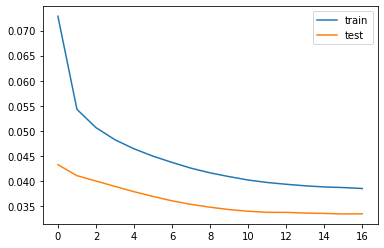

In [19]:
# Loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [20]:
# Predict
y_pred = model.predict(X_test_val)

In [21]:
# Calculate Aggregated Root Mean Squared Error
from sklearn.metrics import mean_squared_error
rmse_arr = []

for i in range(0, len(y_pred)):
    rmse_arr.append(np.sqrt(mean_squared_error(y_pred[i], y_test_val[i])))
    
print(np.mean(rmse_arr))

0.019421384854490763


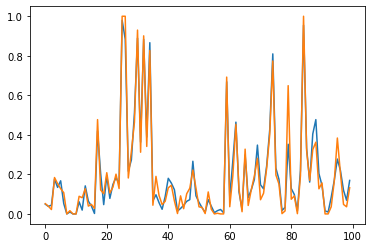

In [22]:
# Plot an interval of demand of t+5
pred = pd.DataFrame(y_pred).iloc[:, 4].values
test = pd.DataFrame(y_test_val).iloc[:, 4].values

plt.plot(pred[1700400:1700500], label='pred')
plt.plot(test[1700400:1700500], label='test')
plt.show()

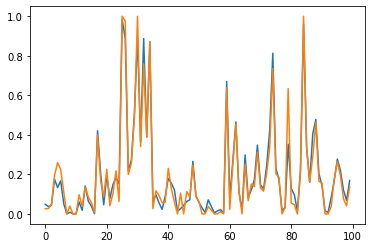

In [23]:
# Plot an interval of demand of t+4
pred = pd.DataFrame(y_pred).iloc[:, 3].values
test = pd.DataFrame(y_test_val).iloc[:, 3].values

plt.plot(pred[1700400:1700500], label='pred')
plt.plot(test[1700400:1700500], label='test')
plt.show()

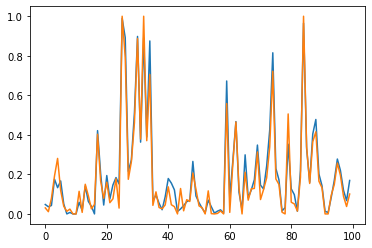

In [24]:
# Plot an interval of demand of t+3
pred = pd.DataFrame(y_pred).iloc[:, 2].values
test = pd.DataFrame(y_test_val).iloc[:, 2].values

plt.plot(pred[1700400:1700500], label='pred')
plt.plot(test[1700400:1700500], label='test')
plt.show()

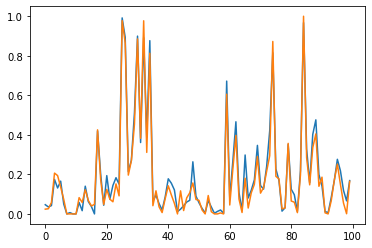

In [25]:
# Plot an interval of demand of t+2
pred = pd.DataFrame(y_pred).iloc[:, 1].values
test = pd.DataFrame(y_test_val).iloc[:, 1].values

plt.plot(pred[1700400:1700500], label='pred')
plt.plot(test[1700400:1700500], label='test')
plt.show()

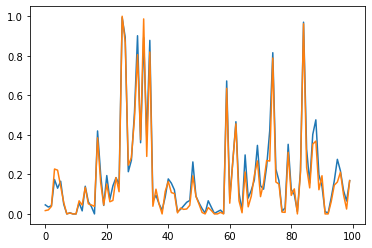

In [26]:
# Plot an interval of demand of t+1
pred = pd.DataFrame(y_pred).iloc[:, 0].values
test = pd.DataFrame(y_test_val).iloc[:, 0].values

plt.plot(pred[1700400:1700500], label='pred')
plt.plot(test[1700400:1700500], label='test')
plt.show()